#**Define useful boilerplate functions**

In [ ]:
import torch, torchvision
import torchvision.transforms as T
from PIL import Image

%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
# Mount my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Check if GPU is available for running
print(torch.__version__, torch.cuda.is_available())
torch.set_grad_enabled(False);

1.13.0+cu116 True


In [ ]:
# standard PyTorch mean-std input image normalization
# DETR resizes images to have a min size of 800 and a max size of 1333
transform = T.Compose([
    T.Resize(600),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

In [ ]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

#**Clone custom code of DETR** (more explanation from [woctezuma](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb))
Clone my fork tailored for a custom dataset:

*   called custom,
*   with max_class_id = 2 (explanation)

**Caveat**: if you later use first_class_index = 1 for your dataset, then it is fine. However, if you later use first_class_index = 0, then you will have to override the value of max_class_id (so that it is equal to 1) when calling !python main.py. My fork can do that.

In [ ]:
#%cd /content/gdrive/MyDrive/Colab Notebooks/DETR2

#!rm -rf detr
#!git clone https://github.com/woctezuma/detr.git

#%cd detr/

#!git checkout finetune

#**Load pre-trained weights** (more explanation from [woctezuma](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb))

Load a check-point (urls can be found here), then remove the classification head.

In [ ]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', map_location='cpu', check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

#**Check the dataset after it was pre-processed for fine-tuning**
To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:

*   Demo of COCO API: https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb

In [ ]:
dataDir='/content/gdrive/MyDrive/Colab Notebooks/DETR2/custom/'
dataType='train2017'
annFile='{}annotations/custom_train.json'.format(dataDir)

In [ ]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())

nms=[cat['name'] for cat in cats]
print('Categories: {}'.format(nms))

nms = set([cat['supercategory'] for cat in cats])
print('Super-categories: {}'.format(nms))

Categories: ['balloon']
Super-categories: {'N/A'}


In [ ]:
# load and display image
catIds = coco.getCatIds(catNms=['balloon']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°35
Image name: /content/gdrive/MyDrive/Colab Notebooks/DETR2/custom//train2017/381b82d49143c34c_jpg.rf.522080d23c4632cf16c3efbc28d4ef2f.jpg


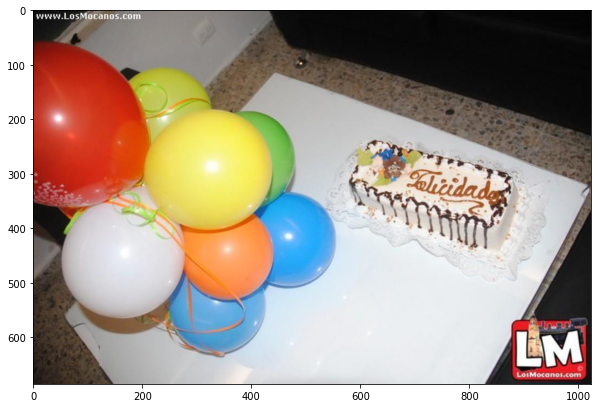

In [ ]:
#load a random image from train2017 folder

img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [ ]:
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
anns = coco.loadAnns(annIds)

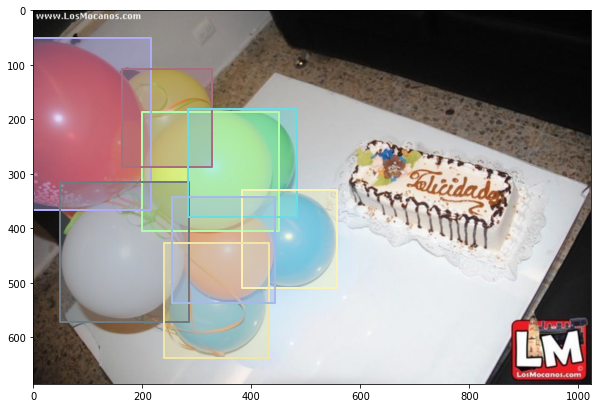

In [ ]:
#display the annotation of balloon in that same image

plt.imshow(I)
coco.showAnns(anns, draw_bbox=True)

#**Fine-tuning** (more explanation from [woctezuma](https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb))
*   Instructions appear in a Github Gist.

NB: There is a 
--frozen_weights argument. However, i) I have yet to figure out how it is used, ii) it is of no use for box detection. Indeed, "frozen training is meant for segmentation only" (as mentioned at this line of the source-code).

#**Boilerplate variables**
Caveat: the parameter name num_classes is misleading. It is actually the ID which DETR will reserve for its own no_object class.

It should be set to one plus the highest class ID in your dataset.

For instance, if you have one class (balloon):

*   if you used the index n°0 for this class, then max_id = 0 and num_classes = max_id+1 = 1
*   if you used the index n°1 for this class, then max_id = 1 and num_classes = max_id+1 = 2

Reference: https://github.com/facebookresearch/detr/issues/108#issuecomment-650269223

In [ ]:
first_class_index = 0
num_classes = 1
finetuned_classes = ['balloon']

print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

First class index: 0
Parameter num_classes: 1
Fine-tuned classes: ['balloon']


In [ ]:
# move directory to the detr folder to start the training process

%cd /content/gdrive/MyDrive/Colab Notebooks/DETR2/detr/

/content/gdrive/MyDrive/Colab Notebooks/DETR2/detr


**Caveat:** below, we override the value of num_classes (hard-coded to 2 for the custom dataset in my finetune branch of DETR) in case first_class_index = 0 instead of first_class_index = 1 (default value).

In [ ]:
!python main.py \
  --dataset_file "custom" \
  --coco_path "/content/gdrive/MyDrive/Colab Notebooks/DETR2/custom/" \
  --output_dir "outputs/10-epochs-2" \
  --resume "detr-r50_no-class-head.pth" \
  --num_classes $num_classes \
  --epochs 10

Not using distributed mode
git:
  sha: 3cda3529921efb8870d0b49db7b30aa8477ae359, status: has uncommited changes, branch: finetune

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='/content/gdrive/MyDrive/Colab Notebooks/DETR2/custom/', dataset_file='custom', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_classes=1, num_queries=100, num_workers=2, output_dir='outputs/10-epochs-2', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
/usr/local/lib/python3.8/dist-packa

#**Check the results**

##**Monitoring of training**

Reference: https://github.com/lessw2020/Thunder-Detr/blob/master/View_your_training_results.ipynb

In [ ]:
from util.plot_utils import plot_logs
from pathlib import Path

log_directory = [Path('outputs/10-epochs-2/')]

As mentioned in the code of plot_logs:

*   solid lines are training results,
*   dashed lines are validation results.

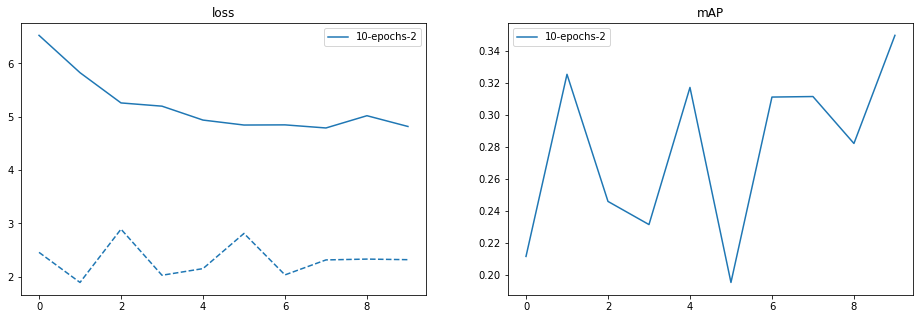

In [ ]:
fields_of_interest = ('loss','mAP')
plot_logs(log_directory, fields_of_interest)

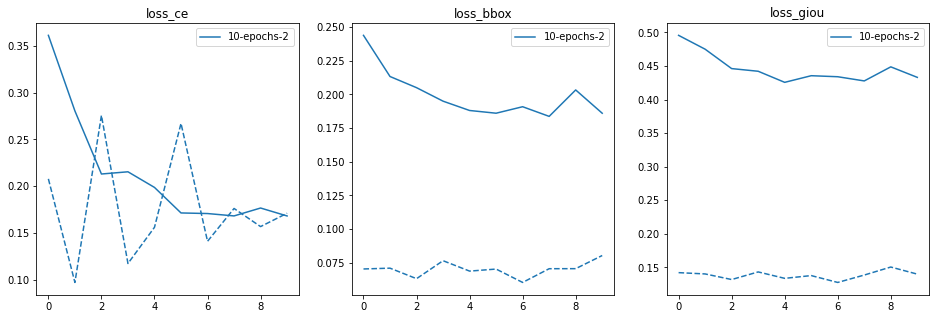

In [ ]:
fields_of_interest = ('loss_ce','loss_bbox','loss_giou')
plot_logs(log_directory, fields_of_interest)

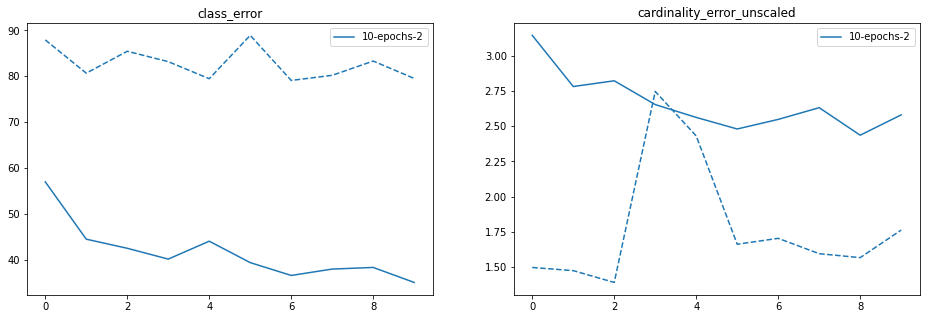

In [ ]:
fields_of_interest = ('class_error', 'cardinality_error_unscaled')
plot_logs(log_directory, fields_of_interest)

#**Load the fine-tuned model**
How to replace the classification head: https://github.com/facebookresearch/detr/issues/9#issuecomment-636391562

In [ ]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=False, num_classes=1)
checkpoint = torch.load('outputs/10-epochs-2/checkpoint.pth', map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)
model.eval();

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#**Boilerplate functions to display fine-tuned results**

In [ ]:
def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    count_balloon = 0
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          cl = p.argmax()
          label = finetuned_classes[cl]
          if label == "balloon":
            count_balloon +=1
            text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
            ax.text(xmin, ymin, text, fontsize=10, bbox=dict(facecolor='yellow', alpha=0.5))
    print("Number of balloons detected: {}".format(count_balloon))
    plt.axis('off')
    plt.show()

In [ ]:
def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  outputs = my_model(img)

  for threshold in [0.9, 0.85, 0.75]:
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=threshold)
    plot_finetuned_results(my_image, probas_to_keep, bboxes_scaled)

#**Test Model**

In [ ]:
test_list = ['alex-starnes-V84WIax02VY-unsplash.jpg',\
'ayla-verschueren-rmbqeD5aGPU-unsplash.jpg',\
'pawtography-perth-3ZvmpgHkqmc-unsplash.jpg',\
'womanizer-toys-BVyqNGy16sk-unsplash.jpg',\
'danilo-batista-eaxg94Ore9Q-unsplash.jpg',\
'rebecca-harris-LgOJYxpaHjQ-unsplash.jpg',\
'piero-regnante-CFaZye73djE-unsplash.jpg',\
'maeva-vigier-NeWnQ9F1Oa0-unsplash.jpg',\
'lee-sh-G0dTGzV91EU-unsplash.jpg',\
'sven-brandsma-3XjrW03i9xc-unsplash.jpg',\
'florencia-viadana-8geO_IoN6A4-unsplash.jpg',\
'chris-benson-IV17FOQnwcE-unsplash.jpg',\
'danie-franco-ZjYIfZ8wf2I-unsplash.jpg',\
'nathan-dumlao-_sjD87tTZTk-unsplash.jpg',\
'roman-synkevych-dc4smzAP_co-unsplash.jpg',\
'sven-brandsma-f8vLO2jZcuE-unsplash.jpg',\
'jon-tyson-kQDvrqx0VO4-unsplash.jpg',\
'ana-maria-berbec-nq6QHnQ6yBI-unsplash.jpg',\
'shraga-kopstein-l73yoSE2f0g-unsplash.jpg',\
'connor-jalbert-JgnXQs8fykw-unsplash.jpg',\
'toro-tseleng-zMUARCt2g7o-unsplash.jpg',\
'danilo-batista-F6Zjw4aHkX0-unsplash.jpg',\
'benjamin-lehman-idC-oDzxM4U-unsplash.jpg',\
'dylan-lu-_TqKscYluI4-unsplash.jpg',\
'ian-sanderson-_-xsDLxJv1w-unsplash.jpg',\
'sarah-hopt-CmFYYDG_7DY-unsplash.jpg',\
'blake-lisk-L1RPC6Tq6vE-unsplash.jpg',\
'luis-alfonso-orellana-965BaO_TfV8-unsplash.jpg',\
'or-hakim-R08wKQCpP6M-unsplash.jpg',\
'alaric-sim-0N4UJja6jEU-unsplash.jpg',\
'nipyata-rC295C45wco-unsplash.jpg',\
'julian-hochgesang-e2mdq5FSZTI-unsplash.jpg',\
'daniela-matthies-yiXS_6T7uoM-unsplash.jpg',\
'keisha-kim-A0AeJyb4lHg-unsplash.jpg',\
'mieczyslaw-markow-TOM14lhb1fQ-unsplash.jpg',\
'ayla-verschueren-VULBdvrCvd4-unsplash.jpg',\
'chip-vincent-DoMStU6Cs68-unsplash.jpg',\
'avinash-kumar-uHBUxADBdoU-unsplash.jpg']

for idx_image in range(0, len(test_list)):
  im = Image.open("/content/gdrive/MyDrive/Colab Notebooks/DETR2/custom/test/"+test_list[idx_image])
  run_worflow(im, model)